In [1]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
import os
import time
import random
# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, TimeDistributed

In [2]:
# define filepath to read data
dir_path = 'CMAPSS-Dataset/CMaps/'
# define column names for easy indexing
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1,22)] 
col_names = index_names + setting_names + sensor_names

In [3]:
train = pd.read_csv((dir_path+'train_FD001.txt'), sep='\s+', header=None, names=col_names)
test = pd.read_csv((dir_path+'test_FD001.txt'), sep='\s+', header=None, names=col_names)
y_test = pd.read_csv((dir_path+'RUL_FD001.txt'), sep='\s+', header=None, names=['RUL'])

In [4]:
train.head()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [5]:
def add_remaining_useful_life(df):
    
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

In [6]:
train = add_remaining_useful_life(train)


In [7]:
train.head()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [8]:
train[index_names+['RUL']].head()

,unit_nr,time_cycles,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


In [9]:
X_train = train[setting_names + sensor_names].copy()
y_train = train['RUL'].copy()
y_train_clipped = y_train.clip(upper=120)
y_test_clipped = y_test.clip(upper=120)

X_test = test.drop('time_cycles', axis=1).groupby('unit_nr').last().copy()

In [10]:
X_train

,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,s_6,s_7,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,21.61,551.43,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,21.61,550.86,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,21.61,550.94,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,21.61,550.68,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


In [11]:
y_train

0        191
1        190
2        189
3        188
4        187
        ... 
20626      4
20627      3
20628      2
20629      1
20630      0
Name: RUL, Length: 20631, dtype: int64

In [12]:
y_train_clipped

0        120
1        120
2        120
3        120
4        120
        ... 
20626      4
20627      3
20628      2
20629      1
20630      0
Name: RUL, Length: 20631, dtype: int64

In [13]:
y_test_clipped

,RUL
0,112
1,98
2,69
3,82
4,91
...,...
95,120
96,82
97,59
98,117


In [14]:
X_test

,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,s_6,s_7,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
unit_nr,,,,,,,,,,,,,,,,,,,,,
1,-0.0006,0.0004,100.0,518.67,642.58,1581.22,1398.91,14.62,21.61,554.42,...,521.79,2388.06,8130.11,8.4024,0.03,393,2388,100.0,38.81,23.3552
2,0.0018,-0.0001,100.0,518.67,642.55,1586.59,1410.83,14.62,21.61,553.52,...,521.74,2388.09,8126.90,8.4505,0.03,391,2388,100.0,38.81,23.2618
3,-0.0016,0.0004,100.0,518.67,642.88,1589.75,1418.89,14.62,21.61,552.59,...,520.83,2388.14,8131.46,8.4119,0.03,395,2388,100.0,38.93,23.2740
4,0.0012,0.0004,100.0,518.67,642.78,1594.53,1406.88,14.62,21.61,552.64,...,521.88,2388.11,8133.64,8.4634,0.03,395,2388,100.0,38.58,23.2581
5,-0.0013,-0.0004,100.0,518.67,642.27,1589.94,1419.36,14.62,21.61,553.29,...,521.00,2388.15,8125.74,8.4362,0.03,394,2388,100.0,38.75,23.4117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,-0.0006,0.0003,100.0,518.67,642.30,1590.88,1397.94,14.62,21.61,553.99,...,522.30,2388.01,8148.24,8.4110,0.03,391,2388,100.0,38.96,23.4606
97,0.0013,-0.0001,100.0,518.67,642.59,1582.96,1410.92,14.62,21.61,554.05,...,521.58,2388.06,8155.48,8.4500,0.03,395,2388,100.0,38.61,23.2953
98,0.0017,0.0001,100.0,518.67,642.68,1599.51,1415.47,14.62,21.61,553.44,...,521.53,2388.09,8146.39,8.4235,0.03,394,2388,100.0,38.76,23.3608


In [15]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE: {}, R2: {}'.format(label, rmse, variance))

In [16]:
# before we start plotting, lets implement the condition specific scaling
def add_operating_condition(df):
    df_op_cond = df.copy()
    
    df_op_cond['setting_1'] = df_op_cond['setting_1'].round()
    df_op_cond['setting_2'] = df_op_cond['setting_2'].round(decimals=2)
    
    # converting settings to string and concatanating makes the operating condition into a categorical variable
    
    df_op_cond['op_cond'] = df_op_cond['setting_1'].astype(str) + '_' + \
                        df_op_cond['setting_2'].astype(str) + '_' + \
                        df_op_cond['setting_3'].astype(str)
    return df_op_cond
    

In [17]:
def condition_scaler(df_train, df_test, sensor_names):
    scaler = StandardScaler()
    for condition in df_train['op_cond'].unique():
        scaler.fit(df_train.loc[df_train['op_cond']==condition, sensor_names])
        df_train.loc[df_train['op_cond'] == condition, sensor_names] =  scaler.transform(df_train.loc[df_train['op_cond'] == condition, sensor_names])
        df_test.loc[df_test['op_cond'] == condition, sensor_names] =  scaler.transform(df_test.loc[df_test['op_cond'] == condition, sensor_names])
        
    return df_train, df_test

In [18]:
X_train_condition = add_operating_condition(train)
X_test_condition = add_operating_condition(X_test)

X_train_condition_scaled, X_test_condition_scaled = condition_scaler(X_train_condition, X_test_condition, sensor_names)

In [19]:
remaining_sensors = ['s_2', 's_3', 's_4', 's_7', 's_8', 's_9',
       's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']
drop_sensors = [element for element in sensor_names if element not in remaining_sensors]

In [20]:
def exponential_smoothing(df, sensors, n_samples, alpha=0.4):
    df = df.copy()
    # first, take the exponential weighted mean
    df[sensors] = df.groupby('unit_nr')[sensors].apply(lambda x: x.ewm(alpha=alpha).mean())
    
    # second, drop first n_samples of each unit_nr to reduce filter delay
    def create_mask(data, samples):
        result = np.ones_like(data)
        result[0:samples] = 0
        return result
    
    mask = df.groupby('unit_nr')['unit_nr'].transform(create_mask, samples= n_samples).astype(bool)
    df = df[mask]
    
    return df

In [21]:
gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)

def train_val_group_split(X, y, gss, groups, print_groups=True):
    for idx_train, idx_val in gss.split(X, y, groups=groups):
        if print_groups:
            print('train_split_engines', train.iloc[idx_train]['unit_nr'].unique())
            print('validate_split_engines', train.iloc[idx_val]['unit_nr'].unique(),'\n')
            
        X_train_split = X.iloc[idx_train].copy()
        y_train_split = y.iloc[idx_train].copy()
        X_val_split = X.iloc[idx_val].copy()
        y_val_split = y.iloc[idx_val].copy()
    return X_train_split, y_train_split, X_val_split, y_val_split

In [22]:
def gen_train_data(df, sequence_length, columns):
    data = df[columns].values
    num_elements = data.shape[0]
    
    for start, stop in zip(range(0, num_elements-(sequence_length-1)), range(sequence_length, num_elements+1)):
        yield data[start:stop, :]

In [23]:
def gen_data_wrapper(df, sequence_length, columns, unit_nrs=np.array([])):
    if unit_nrs.size <= 0:
        unit_nrs = df['unit_nr'].unique()
        
    data_gen = (list(gen_train_data(df[df['unit_nr']== unit_nr], sequence_length, columns))
               for unit_nr in unit_nrs)
    data_array = np.concatenate(list(data_gen)).astype(np.float32)
    
    return data_array

In [24]:
def gen_labels(df, sequence_length, label):
    data_matrix = df[label].values
    num_elements = data_matrix.shape[0]
    
    return data_matrix[sequence_length-1:num_elements, :]

In [25]:
def gen_label_wrapper(df, sequence_length, label, unit_nrs=np.array([])):
    if unit_nrs.size <= 0:
        unit_nrs = df['unit_nr'].unique()
        
    label_gen = [gen_labels(df[df['unit_nr']==unit_nr], sequence_length, label) 
                for unit_nr in unit_nrs]
    label_array = np.concatenate(label_gen).astype(np.float32)
    return label_array

In [26]:
def gen_test_data(df, sequence_length, columns, mask_value):
    if df.shape[0] < sequence_length:
        data_matrix = np.full(shape=(sequence_length, len(columns)), fill_value=mask_value) # pad
        idx = data_matrix.shape[0] - df.shape[0]
        data_matrix[idx:,:] = df[columns].values  # fill with available data
    else:
        data_matrix = df[columns].values
        
    # specifically yield the last possible sequence
    stop = num_elements = data_matrix.shape[0]
    start = stop - sequence_length
    for i in list(range(1)):
        yield data_matrix[start:stop, :]

In [29]:
sequence_length = 30
train['RUL'].clip(upper=120, inplace=True)

In [30]:
X_train_interim = add_operating_condition(train.drop(drop_sensors, axis=1))
X_test_interim = add_operating_condition(test.drop(drop_sensors, axis=1))

In [31]:
X_train_interim, X_test_interim = condition_scaler(X_train_interim, X_test_interim, remaining_sensors)

In [32]:
X_train_interim

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_2,s_3,s_4,s_7,s_8,...,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21,RUL,op_cond
0,1,1,-0.0,-0.0,100.0,-1.711745,-0.135105,-0.911228,1.112411,-0.517249,...,-0.260408,0.325746,-1.051887,-0.275970,-0.588674,-0.786158,1.343200,1.187088,120,-0.0_-0.0_100.0
1,1,2,0.0,-0.0,100.0,-1.062708,0.231118,-0.626194,0.409087,-0.768519,...,-0.172094,1.162967,-0.334446,-0.660992,-0.261707,-0.754587,0.999187,1.223949,120,0.0_-0.0_100.0
2,1,3,-0.0,0.0,100.0,-0.663910,-0.412992,-0.515235,1.006845,-0.233282,...,-1.020631,1.382784,-0.930706,-0.556882,-0.657145,-2.082607,0.743954,0.492172,120,-0.0_0.0_100.0
3,1,4,0.0,0.0,100.0,-0.672971,-1.278257,-0.824098,1.252757,0.161821,...,-1.560422,1.958870,-0.249338,-0.501357,-1.990018,-0.803314,0.371202,0.804103,120,0.0_0.0_100.0
4,1,5,-0.0,-0.0,100.0,-0.609676,-1.237412,-0.295082,0.706914,-0.517249,...,-0.965121,1.043668,-0.775803,-0.522953,-0.326347,-0.140593,0.462474,1.053262,120,-0.0_-0.0_100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0,-0.0,100.0,1.634538,1.197319,2.161826,-2.187880,1.307667,...,1.965001,-2.613668,2.261120,-0.328236,1.427800,2.441667,-1.794387,-2.896429,4,-0.0_-0.0_100.0
20627,100,197,-0.0,-0.0,100.0,1.734726,2.246522,2.704516,-2.829916,1.869180,...,1.853731,-2.356300,1.708952,-0.384602,1.912708,1.150537,-2.840250,-1.192443,3,-0.0_-0.0_100.0
20628,100,198,0.0,0.0,100.0,1.430003,1.940803,2.094823,-2.678385,1.992825,...,2.009102,-1.868559,1.972668,-0.131343,3.236217,3.046747,-2.047352,-3.267717,2,0.0_0.0_100.0
20629,100,199,-0.0,0.0,100.0,1.115559,2.394218,1.981004,-3.077687,2.187541,...,3.226986,-2.373727,1.868912,-0.234282,2.591808,1.164933,-2.950170,-2.118742,1,-0.0_0.0_100.0


In [33]:
X_train_interim = exponential_smoothing(X_train_interim, remaining_sensors, 0, 0.4)
X_test_interim = exponential_smoothing(X_test_interim, remaining_sensors, 0, 0.4)

C:\Users\aara7182\AppData\Local\Temp\ipykernel_74380\3359181580.py:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df[sensors] = df.groupby('unit_nr')[sensors].apply(lambda x: x.ewm(alpha=alpha).mean())
C:\Users\aara7182\AppData\Local\Temp\ipykernel_74380\3359181580.py:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(

In [34]:
# train-val split
gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)
for train_unit, val_unit in gss.split(X_train_interim['unit_nr'].unique(), groups=X_train_interim['unit_nr'].unique()):
    train_unit = X_train_interim['unit_nr'].unique()[train_unit]  # gss returns indexes and index starts at 1
    val_unit = X_train_interim['unit_nr'].unique()[val_unit]


In [35]:
train_unit

array([  2,   3,   4,   6,   7,   8,   9,  10,  12,  14,  15,  16,  17,
        18,  20,  21,  22,  24,  25,  26,  27,  28,  29,  30,  33,  35,
        36,  37,  38,  39,  41,  42,  43,  44,  47,  48,  49,  50,  51,
        52,  53,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  72,  73,  75,  76,  79,  80,  82,  83,
        85,  86,  87,  88,  89,  90,  92,  93,  94,  95,  96,  97,  98,
        99, 100], dtype=int64)

In [36]:
val_unit

array([ 1,  5, 11, 13, 19, 23, 31, 32, 34, 40, 45, 46, 54, 71, 74, 77, 78,
       81, 84, 91], dtype=int64)

In [37]:
train_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, train_unit)
set_split_array = gen_data_wrapper(X_train_interim, sequence_length, setting_names, train_unit)

In [38]:
train_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'], train_unit)

In [39]:
train_split_label

array([[120.],
       [120.],
       [120.],
       ...,
       [  2.],
       [  1.],
       [  0.]], dtype=float32)

In [40]:
val_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, val_unit)
val_set_array = gen_data_wrapper(X_train_interim, sequence_length, setting_names, val_unit)
val_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'], val_unit)

In [41]:
# create sequences train, test 
train_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors)
label_array = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'])
set_array = gen_data_wrapper(X_train_interim, sequence_length, setting_names)

In [42]:
train_array

array([[[-1.711745  , -0.13510469, -0.91122776, ..., -0.78615814,
          1.3432003 ,  1.1870878 ],
        [-1.306097  ,  0.09378423, -0.73308146, ..., -0.766426  ,
          1.1281922 ,  1.2101259 ],
        [-0.9784506 , -0.16477513, -0.6219352 , ..., -1.4379468 ,
          0.93215215,  0.8438231 ],
        ...,
        [-0.5866126 , -0.51064605, -1.0718201 , ..., -0.91061926,
          0.8746341 ,  0.71859664],
        [-0.9699973 , -0.6763934 , -0.99007565, ..., -0.58959013,
          0.7694584 ,  0.6847659 ],
        [-0.9688899 , -0.21147586, -1.1632285 , ..., -1.1867969 ,
          0.98314285,  0.85670644]],

       [[-1.306097  ,  0.09378423, -0.73308146, ..., -0.766426  ,
          1.1281922 ,  1.2101259 ],
        [-0.9784506 , -0.16477513, -0.6219352 , ..., -1.4379468 ,
          0.93215215,  0.8438231 ],
        [-0.83806485, -0.6764858 , -0.7148408 , ..., -1.1462957 ,
          0.6743626 ,  0.8255693 ],
        ...,
        [-0.9699973 , -0.6763934 , -0.99007565, ..., -

In [43]:
label_array

array([[120.],
       [120.],
       [120.],
       ...,
       [  2.],
       [  1.],
       [  0.]], dtype=float32)

In [44]:
set_array

array([[[ -0.,  -0., 100.],
        [  0.,  -0., 100.],
        [ -0.,   0., 100.],
        ...,
        [ -0.,   0., 100.],
        [  0.,  -0., 100.],
        [ -0.,   0., 100.]],

       [[  0.,  -0., 100.],
        [ -0.,   0., 100.],
        [  0.,   0., 100.],
        ...,
        [  0.,  -0., 100.],
        [ -0.,   0., 100.],
        [  0.,   0., 100.]],

       [[ -0.,   0., 100.],
        [  0.,   0., 100.],
        [ -0.,  -0., 100.],
        ...,
        [ -0.,   0., 100.],
        [  0.,   0., 100.],
        [  0.,  -0., 100.]],

       ...,

       [[ -0.,  -0., 100.],
        [ -0.,   0., 100.],
        [ -0.,  -0., 100.],
        ...,
        [ -0.,  -0., 100.],
        [ -0.,  -0., 100.],
        [  0.,   0., 100.]],

       [[ -0.,   0., 100.],
        [ -0.,  -0., 100.],
        [ -0.,   0., 100.],
        ...,
        [ -0.,  -0., 100.],
        [  0.,   0., 100.],
        [ -0.,   0., 100.]],

       [[ -0.,  -0., 100.],
        [ -0.,   0., 100.],
        [  0.,  

In [45]:
test_gen = (list(gen_test_data(X_test_interim[X_test_interim['unit_nr']==unit_nr], sequence_length, remaining_sensors, -99.))
           for unit_nr in X_test_interim['unit_nr'].unique())
test_array = np.concatenate(list(test_gen)).astype(np.float32)
test_gen = (list(gen_test_data(X_test_interim[X_test_interim['unit_nr']==unit_nr], sequence_length, setting_names, -99.))
           for unit_nr in X_test_interim['unit_nr'].unique())
test_set = np.concatenate(list(test_gen)).astype(np.float32)

In [46]:
test_array.shape, train_array.shape

((100, 30, 14), (17731, 30, 14))

In [47]:
import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.utils import plot_model
from IPython.core.display import Image

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing

In [48]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model

from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from IPython.core.display import Image

In [49]:
model_path = './'
model = Sequential()
model.add(Masking(mask_value=-99., input_shape=(sequence_length, train_array.shape[2])))
model.add(LSTM(units=256, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(units=128,return_sequences=False))
model.add(Dropout(0.1))

model.add(Dense(1))
model.add(Activation("linear"))

model.compile(loss='mean_squared_error', optimizer='adam')
model.save_weights('simple_lstm_weights2.h5')

In [50]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 30, 14)            0         
                                                                 
 lstm (LSTM)                 (None, 30, 256)           277504    
                                                                 
 dropout (Dropout)           (None, 30, 256)           0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
 activation (Activation)     (None, 1)                 0

In [51]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [52]:
train_split_array.shape,train_split_label.shape

((14241, 30, 14), (14241, 1))

In [53]:
model.load_weights('simple_lstm_weights2.h5') 
before = time.time()
history = model.fit(train_split_array, train_split_label,
                    validation_data=(val_split_array, val_split_label),
                    epochs=100,
                    batch_size=128,
                    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                    keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

after = time.time()
duration2 = after - before
print("Training time : ",duration2)

Epoch 1/100
112/112 [==============================] - ETA: 0s - loss: 5410.7778

INFO:tensorflow:Assets written to: .\assets


INFO:tensorflow:Assets written to: .\assets


112/112 [==============================] - 30s 224ms/step - loss: 5410.7778 - val_loss: 4347.4297
Epoch 2/100
112/112 [==============================] - ETA: 0s - loss: 3817.3389

INFO:tensorflow:Assets written to: .\assets


INFO:tensorflow:Assets written to: .\assets


112/112 [==============================] - 22s 201ms/step - loss: 3817.3389 - val_loss: 3215.8367
Epoch 3/100
112/112 [==============================] - ETA: 0s - loss: 2776.3840

INFO:tensorflow:Assets written to: .\assets


INFO:tensorflow:Assets written to: .\assets


112/112 [==============================] - 27s 237ms/step - loss: 2776.3840 - val_loss: 2254.6045
Epoch 4/100
112/112 [==============================] - ETA: 0s - loss: 1984.5846

INFO:tensorflow:Assets written to: .\assets


INFO:tensorflow:Assets written to: .\assets


112/112 [==============================] - 30s 271ms/step - loss: 1984.5846 - val_loss: 1613.1738
Epoch 5/100
112/112 [==============================] - ETA: 0s - loss: 1414.6033

INFO:tensorflow:Assets written to: .\assets


INFO:tensorflow:Assets written to: .\assets


112/112 [==============================] - 42s 377ms/step - loss: 1414.6033 - val_loss: 1144.4233
Epoch 6/100
112/112 [==============================] - ETA: 0s - loss: 1004.8311

INFO:tensorflow:Assets written to: .\assets


INFO:tensorflow:Assets written to: .\assets


112/112 [==============================] - 47s 422ms/step - loss: 1004.8311 - val_loss: 805.7361
Epoch 7/100
112/112 [==============================] - ETA: 0s - loss: 745.6780

INFO:tensorflow:Assets written to: .\assets


INFO:tensorflow:Assets written to: .\assets


112/112 [==============================] - 44s 396ms/step - loss: 745.6780 - val_loss: 588.0544
Epoch 8/100
112/112 [==============================] - ETA: 0s - loss: 546.5151

INFO:tensorflow:Assets written to: .\assets


INFO:tensorflow:Assets written to: .\assets


112/112 [==============================] - 58s 515ms/step - loss: 546.5151 - val_loss: 451.4594
Epoch 9/100
112/112 [==============================] - ETA: 0s - loss: 418.0974

INFO:tensorflow:Assets written to: .\assets


INFO:tensorflow:Assets written to: .\assets


112/112 [==============================] - 62s 558ms/step - loss: 418.0974 - val_loss: 358.9786
Epoch 10/100
112/112 [==============================] - ETA: 0s - loss: 331.5938

INFO:tensorflow:Assets written to: .\assets


INFO:tensorflow:Assets written to: .\assets


112/112 [==============================] - 56s 500ms/step - loss: 331.5938 - val_loss: 262.4236
Epoch 11/100
112/112 [==============================] - 50s 444ms/step - loss: 969.0366 - val_loss: 426.4884
Epoch 12/100
112/112 [==============================] - 50s 445ms/step - loss: 462.2658 - val_loss: 323.3595
Epoch 13/100
112/112 [==============================] - ETA: 0s - loss: 326.8608

INFO:tensorflow:Assets written to: .\assets


INFO:tensorflow:Assets written to: .\assets


112/112 [==============================] - 58s 523ms/step - loss: 326.8608 - val_loss: 224.2365
Epoch 14/100
112/112 [==============================] - ETA: 0s - loss: 268.2289

INFO:tensorflow:Assets written to: .\assets


INFO:tensorflow:Assets written to: .\assets


112/112 [==============================] - 57s 507ms/step - loss: 268.2289 - val_loss: 194.8664
Epoch 15/100
112/112 [==============================] - ETA: 0s - loss: 238.6696

INFO:tensorflow:Assets written to: .\assets


INFO:tensorflow:Assets written to: .\assets


112/112 [==============================] - 64s 570ms/step - loss: 238.6696 - val_loss: 184.3972
Epoch 16/100
112/112 [==============================] - ETA: 0s - loss: 217.5846

INFO:tensorflow:Assets written to: .\assets


INFO:tensorflow:Assets written to: .\assets


112/112 [==============================] - 65s 580ms/step - loss: 217.5846 - val_loss: 180.6337
Epoch 17/100
112/112 [==============================] - ETA: 0s - loss: 195.7260

INFO:tensorflow:Assets written to: .\assets


INFO:tensorflow:Assets written to: .\assets


112/112 [==============================] - 62s 556ms/step - loss: 195.7260 - val_loss: 149.2998
Epoch 18/100
112/112 [==============================] - 45s 398ms/step - loss: 180.2827 - val_loss: 162.5363
Epoch 19/100
112/112 [==============================] - 45s 401ms/step - loss: 179.8918 - val_loss: 152.8681
Epoch 20/100
112/112 [==============================] - ETA: 0s - loss: 171.3515

INFO:tensorflow:Assets written to: .\assets


INFO:tensorflow:Assets written to: .\assets


112/112 [==============================] - 54s 479ms/step - loss: 171.3515 - val_loss: 145.2868
Epoch 21/100
112/112 [==============================] - 56s 498ms/step - loss: 163.4455 - val_loss: 172.9703
Epoch 22/100
112/112 [==============================] - 56s 502ms/step - loss: 163.3749 - val_loss: 147.3504
Epoch 23/100
112/112 [==============================] - 56s 503ms/step - loss: 155.5392 - val_loss: 147.7064
Epoch 24/100
112/112 [==============================] - 56s 499ms/step - loss: 152.7067 - val_loss: 148.3405
Epoch 25/100
112/112 [==============================] - 57s 508ms/step - loss: 159.8920 - val_loss: 154.0461
Epoch 26/100
112/112 [==============================] - 57s 513ms/step - loss: 197.5327 - val_loss: 183.6340
Epoch 27/100
112/112 [==============================] - 56s 500ms/step - loss: 174.1239 - val_loss: 173.6711
Epoch 28/100
112/112 [==============================] - 56s 505ms/step - loss: 157.6874 - val_loss: 153.0332
Epoch 29/100
112/112 [==========

INFO:tensorflow:Assets written to: .\assets


INFO:tensorflow:Assets written to: .\assets


112/112 [==============================] - 65s 582ms/step - loss: 153.0182 - val_loss: 139.2621
Epoch 31/100
112/112 [==============================] - ETA: 0s - loss: 141.5861

INFO:tensorflow:Assets written to: .\assets


INFO:tensorflow:Assets written to: .\assets


112/112 [==============================] - 72s 642ms/step - loss: 141.5861 - val_loss: 128.9236
Epoch 32/100
112/112 [==============================] - 59s 526ms/step - loss: 138.7209 - val_loss: 135.0870
Epoch 33/100
112/112 [==============================] - 61s 541ms/step - loss: 142.8699 - val_loss: 132.1804
Epoch 34/100
112/112 [==============================] - 59s 528ms/step - loss: 135.1703 - val_loss: 134.8789
Epoch 35/100
112/112 [==============================] - 59s 531ms/step - loss: 130.7614 - val_loss: 133.6232
Epoch 36/100
112/112 [==============================] - 60s 537ms/step - loss: 131.0860 - val_loss: 148.2376
Epoch 37/100
112/112 [==============================] - ETA: 0s - loss: 125.2475

INFO:tensorflow:Assets written to: .\assets


INFO:tensorflow:Assets written to: .\assets


112/112 [==============================] - 69s 615ms/step - loss: 125.2475 - val_loss: 125.2847
Epoch 38/100
112/112 [==============================] - 61s 541ms/step - loss: 124.5448 - val_loss: 136.9599
Epoch 39/100
112/112 [==============================] - 60s 540ms/step - loss: 125.0701 - val_loss: 136.5880
Epoch 40/100
112/112 [==============================] - 60s 540ms/step - loss: 123.8333 - val_loss: 147.7061
Epoch 41/100
112/112 [==============================] - 60s 539ms/step - loss: 121.1873 - val_loss: 132.9247
Epoch 42/100
112/112 [==============================] - 60s 534ms/step - loss: 122.5120 - val_loss: 132.0368
Epoch 43/100
112/112 [==============================] - 60s 533ms/step - loss: 121.5957 - val_loss: 134.6084
Epoch 44/100
112/112 [==============================] - 59s 530ms/step - loss: 121.2477 - val_loss: 129.8007
Epoch 45/100
112/112 [==============================] - 59s 531ms/step - loss: 120.0359 - val_loss: 129.6493
Epoch 46/100
112/112 [==========

In [54]:
# plot history
def plot_loss(fit_history):
    plt.figure(figsize=(13,5))
    plt.plot(range(1, len(fit_history.history['loss'])+1), fit_history.history['loss'], label='train')
    plt.plot(range(1, len(fit_history.history['val_loss'])+1), fit_history.history['val_loss'], label='validate')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

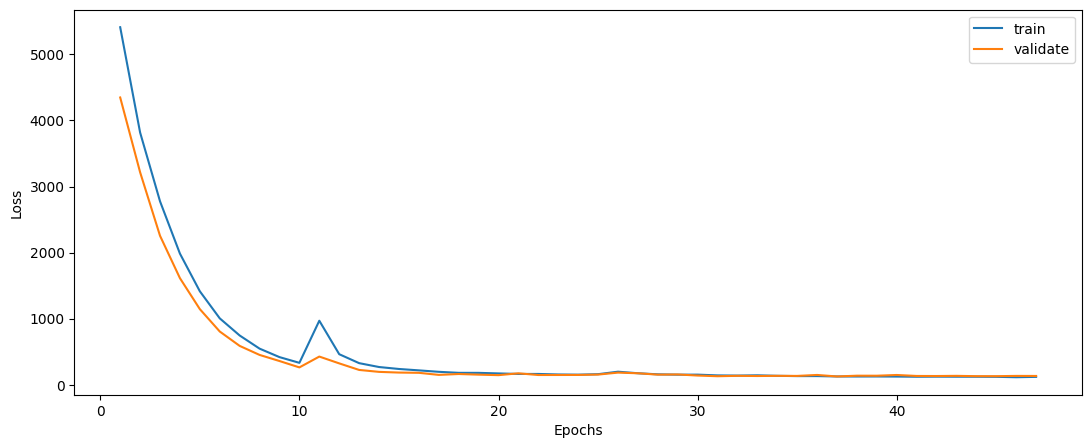

In [55]:
plot_loss(history)

In [56]:
y_hat_train = model.predict(train_array)

555/555 [==============================] - 26s 45ms/step


In [57]:
evaluate(label_array, y_hat_train, 'train')

train set RMSE: 10.38437557220459, R2: 0.9332180436201801


In [58]:
y_hat_test = model.predict(test_array)

4/4 [==============================] - 0s 36ms/step


In [59]:
evaluate(y_test, y_hat_test)

test set RMSE: 14.679795169957243, R2: 0.8752098095699293


In [60]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("model2.h5")
print("Saved model to disk")

Saved model to disk


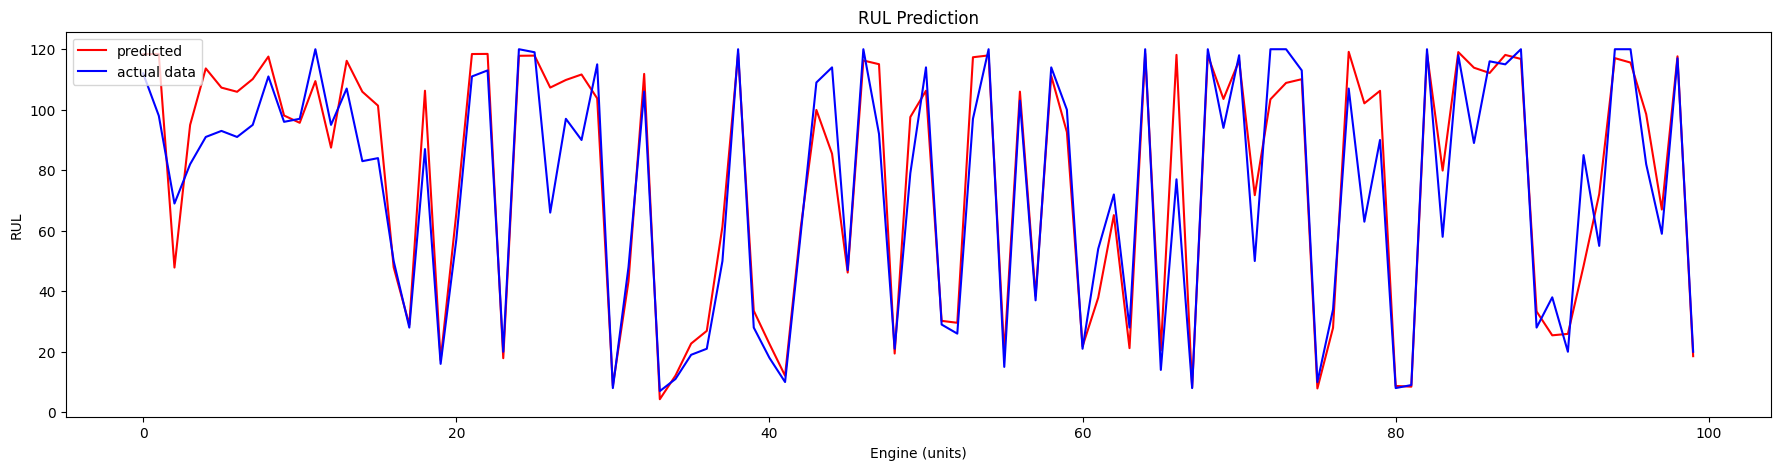

In [61]:
plt.figure(figsize=(22,5))
plt.plot(y_hat_test[0:1400], color="red")
plt.plot(y_test_clipped[0:1400], color="blue")
plt.title('RUL Prediction')
plt.ylabel('RUL')
plt.xlabel('Engine (units)')
plt.legend(['predicted', 'actual data'], loc='upper left')
plt.show()
           

### Load Saved Model and re-use it 

In [62]:
from tensorflow.keras.models import model_from_json
new_model = model_from_json(model_json) 

In [67]:
new_model.load_weights('model2.h5')

In [68]:
new_model.compile(loss='mean_squared_error', optimizer='adam')

In [69]:
y_hat_test = new_model.predict(test_array)

4/4 [==============================] - 2s 29ms/step


In [70]:
evaluate(y_test, y_hat_test)

test set RMSE: 14.679795169957243, R2: 0.8752098095699293
